In [1]:
import gc
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

As the training data is very large, I used the feather format of the training data from [here](https://www.kaggle.com/rohanrao/riiid-train-data-multiple-formats). The loading time is drastically reduced compared to that of reading a csv file.
As we can see, there are nearly 101 million rows in the dataset

In [2]:
%%time
df = pd.read_feather('../input/riiid-train-data-multiple-formats/riiid_train.feather')
df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('boolean')
print('Size of Training Data : ', df.shape)

Size of Training Data :  (101230332, 10)
CPU times: user 32.7 s, sys: 10.7 s, total: 43.4 s
Wall time: 47.6 s


In [3]:
# Dataset used : https://www.kaggle.com/c/riiid-test-answer-prediction
questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

# **Exploring Train**

Let us see the memory usage of the training data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: bool(1), boolean(1), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.1 GB


**Brief idea about the training data**

**row_id**: (int64) ID code for the row.

**timestamp**: (int64) the time between this user interaction and the first event from that user.

**user_id**: (int32) ID code for the user.

**content_id**: (int16) ID code for the user interaction

**content_type_id**: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

**task_container_id**: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

**user_answer**: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

**answered_correctly**: (int8) if the user responded correctly. Read -1 as null, for lectures.

**prior_question_elapsed_time**: (float32) How long it took a user to answer their previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Note that the time is the total time a user took to solve all the questions in the previous bundle.

**prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [5]:
df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False


Each **user_id** is a unique code to address each student

In [6]:
# total no. of students
print(f'There are {df.user_id.nunique()} students in the data')

There are 393656 students in the data


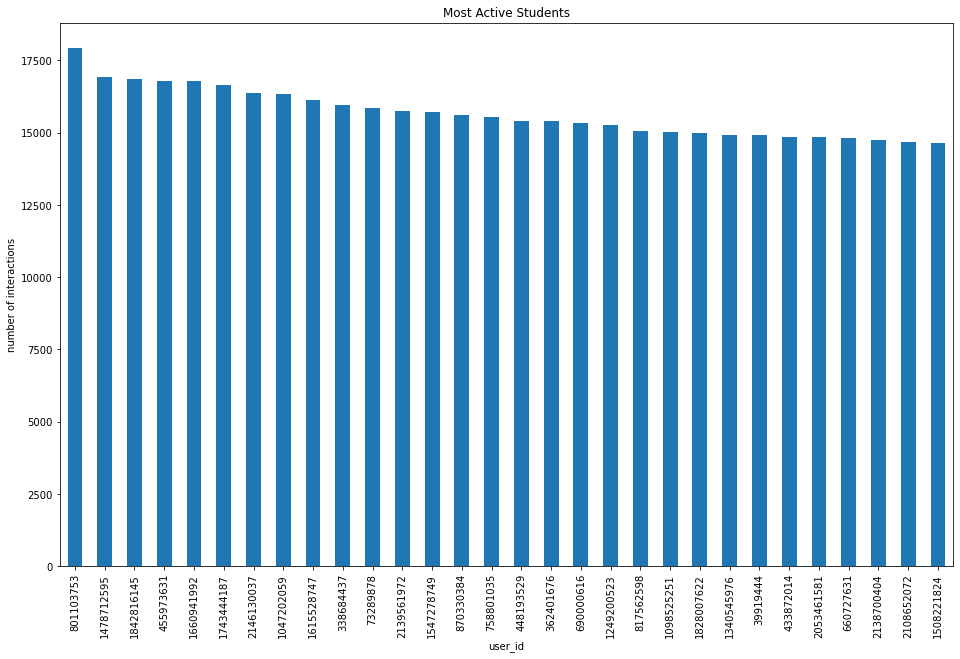

In [7]:
# 30 Most active students
x = df.user_id.value_counts()[:30]
fig = plt.figure(figsize = (16,10))
plt.title('Most Active Students')
ax = x.plot.bar(xlabel = 'user_id', ylabel = 'number of interactions')
plt.show()

If an interaction was a lecture, then **content_type_id** will be True. If **content_type_id** is False, it means that a question was asked

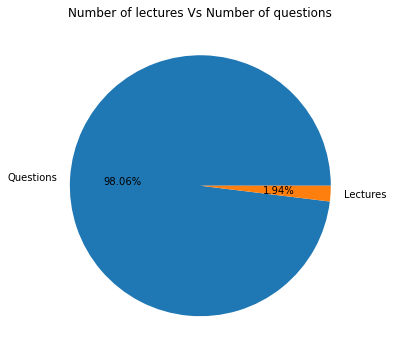

In [8]:
# Lectures Vs Questions
fig = plt.figure(figsize = (10, 6))
plt.title('Number of lectures Vs Number of questions')
ax = df.content_type_id.value_counts().plot.pie(labels=['Questions','Lectures'], autopct='%1.2f%%')
ax.yaxis.set_visible(False)
plt.show()

Each **content_id** represents a user interaction (i.e question or lecture) 

In [9]:
print(f'Out of {df.content_id.nunique()} different user interactions, {df[df.content_type_id == False].content_id.nunique()} are questions')

Out of 13782 different user interactions, 13523 are questions


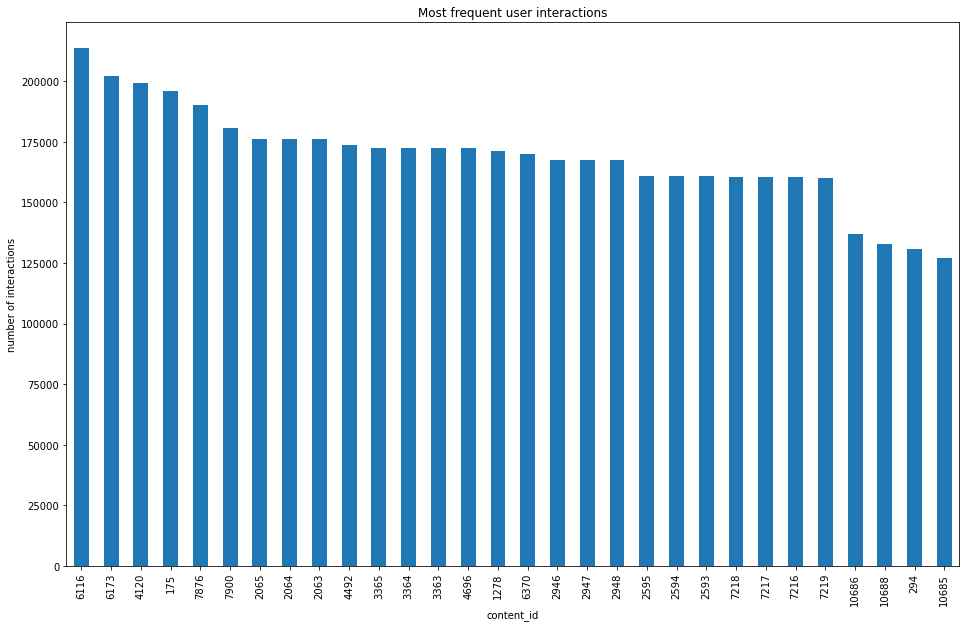

In [10]:
# 30 most frequent content_id interactions
x = df.content_id.value_counts()[:30]
fig = plt.figure(figsize = (16,10))
plt.title('Most frequent user interactions')
ax = x.plot.bar(xlabel = 'content_id', ylabel = 'number of interactions')
plt.show()

In [11]:
# batches of questions
print(f'There are a total of {df.task_container_id.nunique()} batches of interactions')

There are a total of 10000 batches of interactions


User answers take values of -1, 0, 1, 2, 3. If answer is -1 it means that the interaction was a lecture. In all other cases, the answer is the student's response

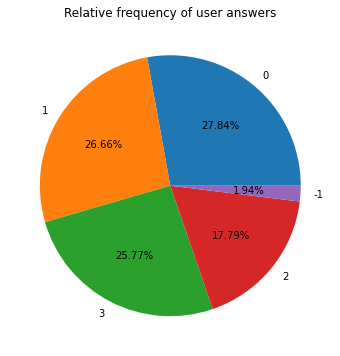

In [12]:
# User answers relative frequency
fig = plt.figure(figsize = (10, 6))
plt.title('Relative frequency of user answers')
ax = df.user_answer.value_counts().plot.pie(autopct='%1.2f%%')
ax.yaxis.set_visible(False)
plt.show()

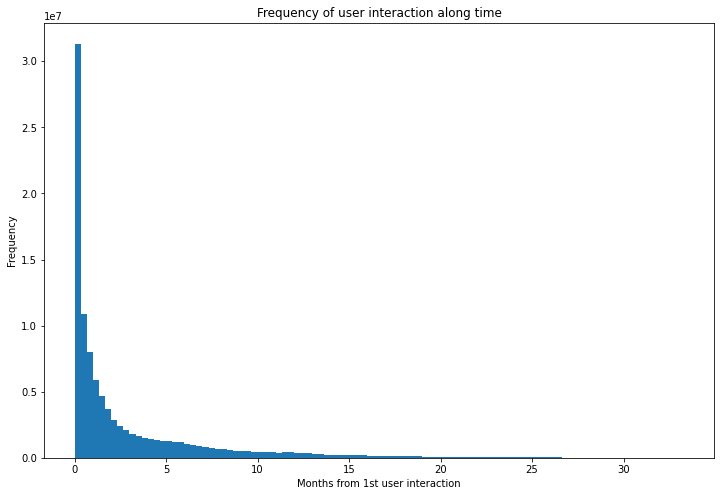

In [13]:
# Frequency plot of time between user interaction from 1st interaction
# 1 year = 31536000000 ms
ts = df['timestamp']/(31536000000/12) # time in months
fig = plt.figure(figsize = (12,8))
ts.plot.hist(bins = 100)
plt.title('Frequency of user interaction along time')
plt.xlabel('Months from 1st user interaction')
plt.show()
# No. interactions decrease along time

# Target : Answered_correctly
 If answered_correctly = -1, it means that the interaction was a lecture

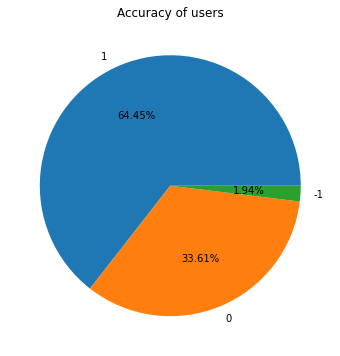

In [14]:
del ts
_ = gc.collect()
# percentage of correct answers
x = df.answered_correctly.value_counts()
fig = plt.figure(figsize = (10, 6))
plt.title('Accuracy of users')
ax = df.answered_correctly.value_counts().plot.pie(autopct='%1.2f%%')
ax.yaxis.set_visible(False)
plt.show()

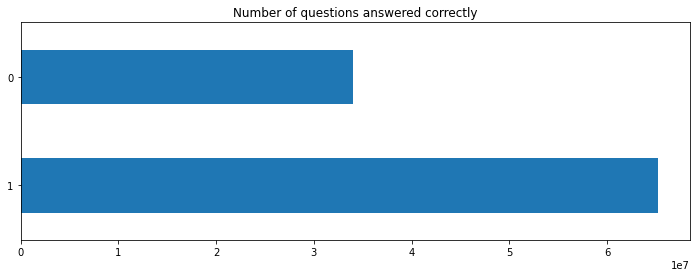

In [15]:
x = df[df.answered_correctly != -1].answered_correctly.value_counts()
fig = plt.figure(figsize = (12,4))
ax = x.plot.barh()
plt.title('Number of questions answered correctly')
plt.show()

**timestamp**: (int64) the time between this user interaction and the first event from that user.

Let us see the relation between **timestamp** and the target. I divided the data into 5 bins based on **timestamp** value. We can see that performance of recently joined students is a bit less compared to students who registered long ago.

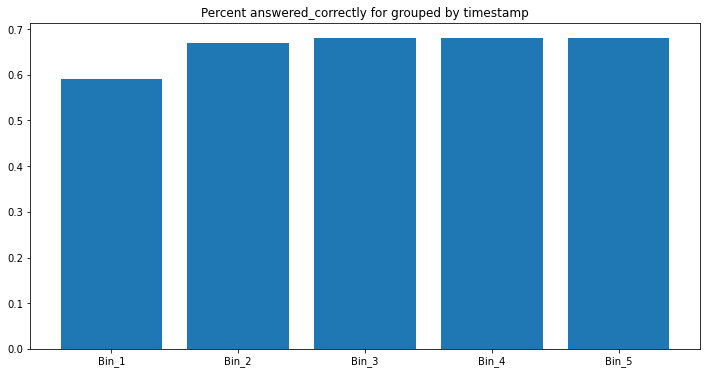

In [16]:
# percent correct gouped by timestamp
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5']
df['ts_bin'] = pd.qcut(df['timestamp'], q = 5, labels = bin_labels_5)

# make function that can also be used for other fields
def correct(field):
    correct = df[df.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.iloc[:,2]
    return correct

bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
plt.title("Percent answered_correctly for grouped by timestamp")
plt.xticks(rotation = 0)
plt.show()

**task_container_id**: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id. Monotonically increasing for each user.

Now let us see how tough questions are when grouped by the batch number i.e **task_container_id**

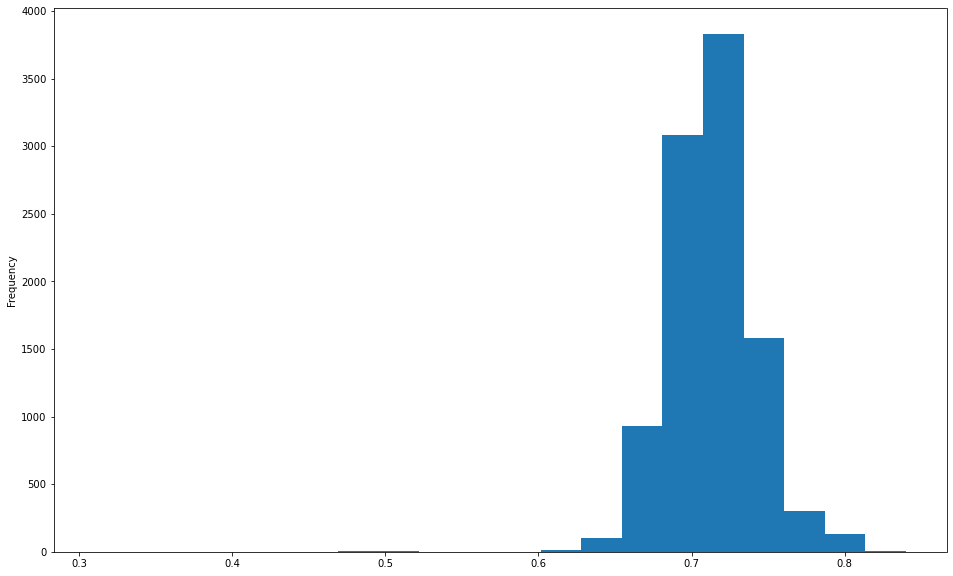

In [17]:
# percent correct grouped by task_id
task_id_correct = correct('task_container_id')
fig = plt.figure(figsize = (16,10))
task_id_correct.plot.hist(bins = 20)
plt.show()

Now we group the target based on **prior_question_had_explanation** which tells if the student saw the correct answer and explanation of the previous question. If the question is the student's first question, the value is Nan

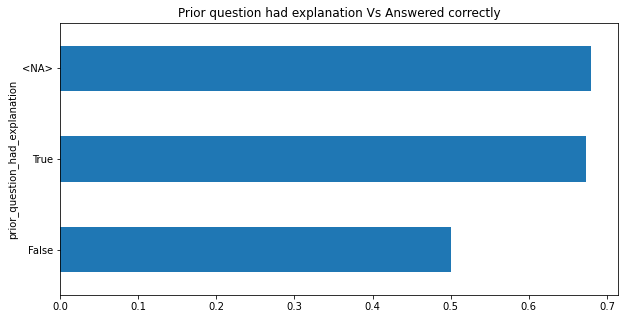

In [18]:
# how much previous explanation helps to answer correctly
x = df[df.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna = False).agg({'answered_correctly': ['mean', 'count']})
fig = plt.figure(figsize = (10,5))
x.iloc[:,0].plot.barh()
plt.title('Prior question had explanation Vs Answered correctly')
plt.show()

**prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

It does not seem to give any important information as there is not much of a difference between the mean for correctly and incorrectly answered questions

In [19]:
# mean prior_question_elapsed_time Vs correctly answered 
x = df[df.answered_correctly != -1].groupby('answered_correctly').agg({'prior_question_elapsed_time' : ['mean'],'answered_correctly' : ['count']})
x

,prior_question_elapsed_time,answered_correctly
,mean,count
answered_correctly,,
0,25641.992188,34026673
1,25309.976562,65244627


In [20]:
# max no. of questions answered by 1 student
x = df[df.answered_correctly != -1].groupby('user_id')
print(f'The maximum number of questions answered by any student is {x.size().max()}')

The maximum number of questions answered by any student is 17609


# Exploring Questions

**Metadata for the questions posed to users**

**question_id**: foreign key for the train/test content_id column, when the content type is question (0).

**bundle_id**: code for which questions are served together.
correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

**part**: the relevant section of the TOEIC test.

**tags**: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [21]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


As described above, tags give important information about questions. Let us check for any questions without any tags

In [22]:
questions[questions.tags.isna()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [23]:
# no. of tags
tags = []
questions.tags = questions.tags.astype(str)
for x in questions.tags.values:
    if x == "nan": continue
    tags.extend(x.split())
    
tags = list(set(tags))
print(f'There are a total of {len(tags)} unique tags describing questions')

There are a total of 188 unique tags describing questions


Now we will see how many times each question was answered correctly and incorrectly

In [24]:
x = df[df.answered_correctly != -1].groupby(['content_id','answered_correctly'],as_index = False).size()
x = x.pivot(index = 'content_id', columns = 'answered_correctly', values = 'size')
x.columns = ['Wrong', 'Right']
x = x.fillna(0).astype(int)
questions[['Wrong', 'Right']] = x
tags_list = [x.split() for x in questions.tags.values]
questions.tags = tags_list
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


Now let us see how accurately all questions related to a tag are answered

In [25]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df2 = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df2.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df2)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

tags_df.head()

,Wrong,Right,Total_questions,Question_ids_with_tag,Percent_correct
tag,,,,,
24,157631,98982,256613,17,0.385725
23,261611,204293,465904,11,0.438487
19,173602,136367,309969,57,0.439938
151,272267,264913,537180,16,0.493155
167,170386,170681,341067,11,0.500432


Let us now visualize the difference between accuracies of the easiest and toughest tags

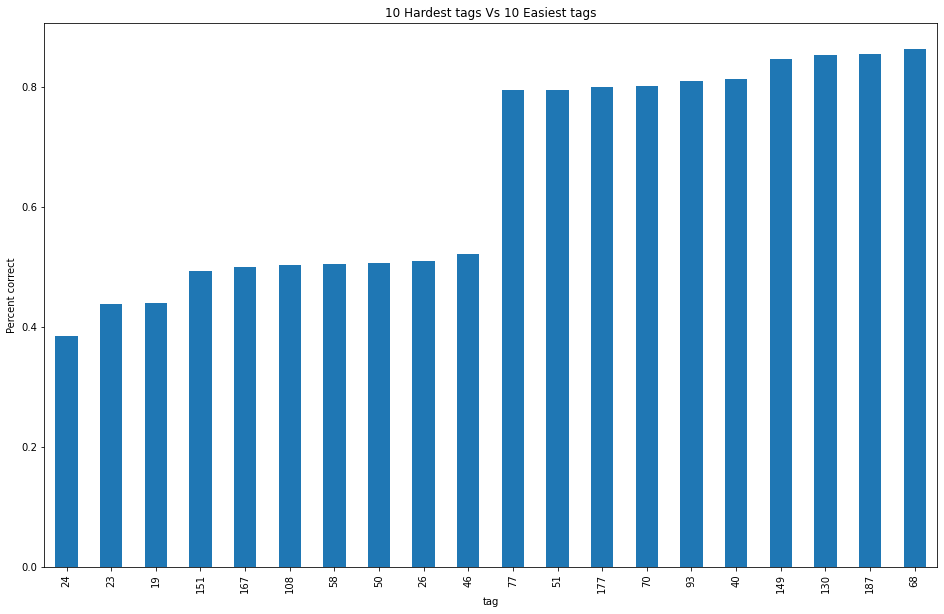

In [26]:
# top 10 hardest Vs easiest tags
fig = plt.figure(figsize = (16,10))
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]
tags_select.plot.bar()
plt.ylabel('Percent correct')
plt.title('10 Hardest tags Vs 10 Easiest tags')
plt.show()

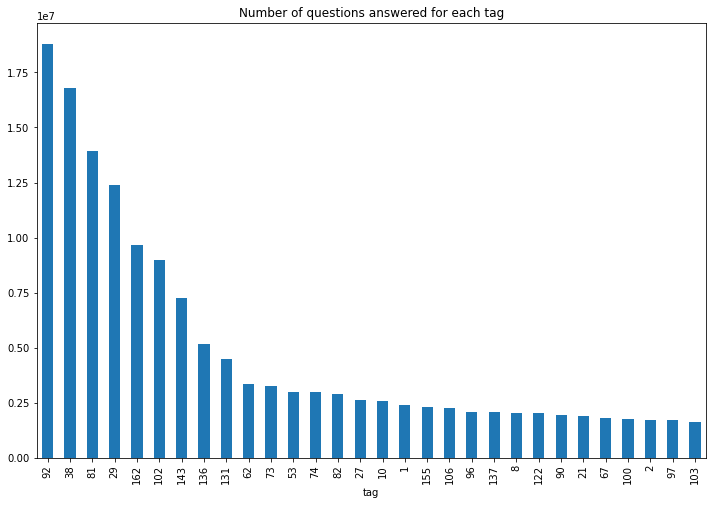

In [27]:
# no. of questions answered for each tag
tags_select = tags_df.sort_values(by = "Total_questions", ascending = False).Total_questions[:30]
fig = plt.figure(figsize = (12,8))
tags_select.plot.bar()
plt.title('Number of questions answered for each tag')
plt.show()

Let us now analyse the **parts** feature of the questions. In the TOEIC test : 

The listening section consists of Part 1-4 (Listening Section (approx. 45 minutes, 100 questions)).

The reading section consists of Part 5-7 (Reading Section (75 minutes, 100 questions)).

We will see the frequency of each part and how accurately questions of a part are answered

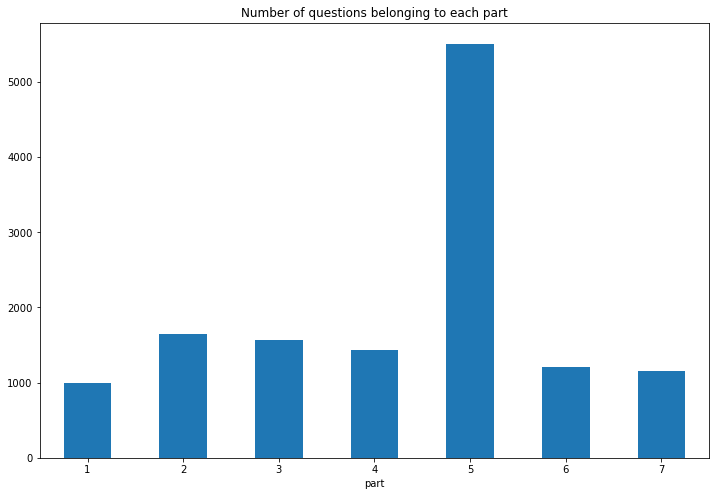

In [28]:
part_counts = questions.groupby('part').size()
parts = questions.groupby('part').agg({'Wrong': ['sum'], 'Right': ['sum']})
parts['percent'] = parts.Right/(parts.Right + parts.Wrong)
# total no. of questions of each part
fig = plt.figure(figsize = (12,8))
plt.title('Number of questions belonging to each part')
ax = part_counts.plot.bar()
plt.xticks(rotation=0)
plt.show()

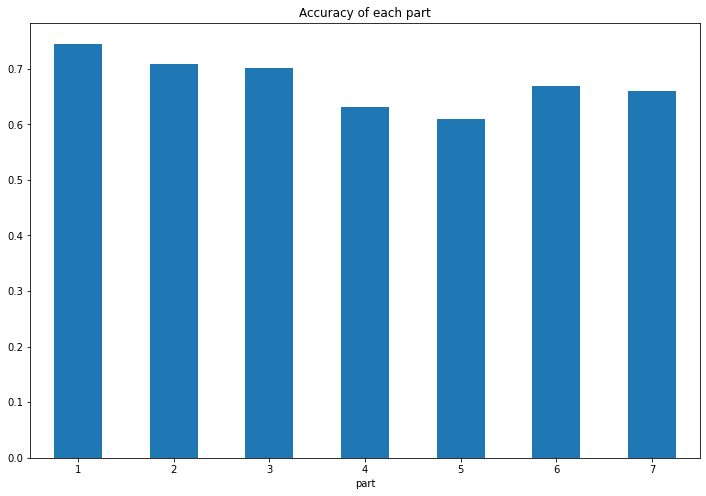

In [29]:
# percentage correct of each part
fig = plt.figure(figsize = (12,8))
ax = parts.percent.plot.bar()
plt.title('Accuracy of each part')
plt.xticks(rotation=0)
plt.show()

# Exploring Lectures

**Metadata for the lectures watched by users as they progress in their education.**

**lecture_id**: foreign key for the train/test content_id column, when the content type is lecture (1).

**part**: top level category code for the lecture.

**tag**: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

**type_of**: brief description of the core purpose of the lecture

In [30]:
# no. of lectures
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


Let us see the frequency of each **type_of** lecture

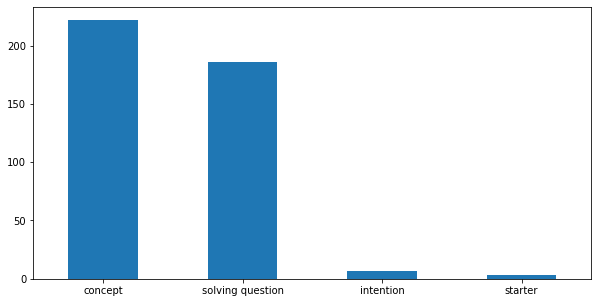

In [31]:
# no. of lecture types per type_of
x = lectures.type_of.value_counts()
fig = plt.figure(figsize = (10,5))
x.plot.bar()
plt.xticks(rotation = 0)
plt.show()